### Analysis of dead-time vs time

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import lmfit

from model_equations_and_simulators.TCS_model_growth_equations import run_TCS_model

In [2]:
# Define the simulation timescale 

t_final = 960 # min 
N_steps = 960 

timepoints = np.linspace(0, t_final, N_steps)

In [3]:
# define model parameters 

p = pd.read_csv('parameters/TCS_model_param_file.csv').to_numpy()
p = p[:,2]

params = lmfit.Parameters()

params.add(name = 'k_green', value = p[0], min = 1e-3, max = 1e4, vary = 1)
params.add(name = 'k_red', value = p[1], min = 1e0, max = 1e4, vary = 1)
params.add(name = 'b_green', value = p[2], min = 1e-4, max = 1e4, vary = 1)
params.add(name = 'b_red', value = p[3], min = 1e0, max = 1e4, vary = 1)

params.add(name = 'k_sp_b', value = p[4], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_sp_u', value = p[5], min = 1e-3, max = 1e3, vary = 1)

params.add(name = 'k_rp_b', value = p[6], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_rp_u', value = p[7], min = 1e-3, max = 1e3, vary = 1)

params.add(name = 'beta', value = p[8], min = 1e-1, max = 200, vary = 1)
params.add(name = 'l0', value = p[9], min = 0, max = 0.5, vary = 1)
params.add(name = 'Kc', value = p[10], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'd_m', value = p[11], min = 0.05, max = 0.3, vary = 1)
params.add(name = 'k_tl', value = p[12], min = 0.1, max = 5, vary = 1)
params.add(name = 'k_tli_b', value = p[13], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'k_tli_u', value = p[14], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'd_p', value = p[15], min = 1e-6, max = 1e-1, vary = 1)
params.add(name = 'k_fold', value = p[16], min = 0.05, max = 0.3, vary = 1)
params.add(name = 'b_fold', value = p[17], min = 0.1, max = 2, vary = 1)
params.add(name = 'n_gamma', value = p[18], min = 0.2, max = 0.9, vary = 1)
params.add(name = 'R_max', value = p[19], min = 1e0, max = 1e4, vary = 1)

params.add(name = 'S_0', value = p[20], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'R_0', value = p[21], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Sp_0', value = p[22], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Rp_0', value = p[23], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'mRNA_0', value = p[24], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'P_0', value = p[25], min = 1e-3, max = 1e3, vary = 1)
params.add(name = 'Pm_0', value = p[26], min = 1e-3, max = 1e3, vary = 1)


params.add(name = 'k_gr', value = p[27], vary = 0)
params.add(name = 'C_max', value = p[28], vary = 0)
params.add(name = 'C_0', value = p[29], vary = 0)

params.add(name = 'n_tcs', value = p[30], min = 0.1, max = 5, vary = 1)


#params.export_to_csv('TCS_params_021225.csv')
n_params = len(params.valuesdict().keys())
param_dict = params.valuesdict()
param_names = list(params.valuesdict().keys())

In [4]:
# define initial conditions and solve the ODEs

x0 = np.zeros(10)

x0[0] = p[20] # S
x0[1] = p[22]# Sp
x0[2] = p[21] # R
x0[3] = p[23] # Rp
x0[4] = 0 # Ac
x0[5] = p[24] # mRNA
x0[6] = 0 # Ctic
x0[7] = p[25] # Unfolded Protein 
x0[8] = p[26] # Folded Protein 
x0[9] = p[29] # Initial Cell count

sol_green = run_TCS_model(x0, timepoints, params, input = 'green')
sol_red = run_TCS_model(x0, timepoints, params, input = 'red')
sol_dark = run_TCS_model(x0, timepoints, params, input = 'dark')

sol_green = sol_green.y.T
sol_red = sol_red.y.T
sol_dark = sol_dark.y.T

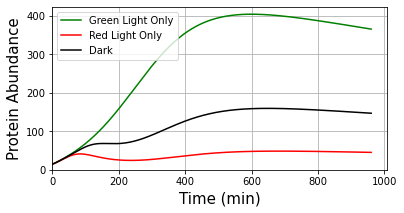

In [5]:
# Plot protein profile (sanity check for the model)

fig, ax = plt.subplots(1,1, figsize = (6,3))


ax.plot(timepoints, sol_green[:,8], 'green', label = 'Green Light Only')
ax.plot(timepoints, sol_red[:,8], 'red', label = 'Red Light Only')
ax.plot(timepoints, sol_dark[:,8], 'black', label = 'Dark')
ax.set_xlabel('Time (min)', fontsize = 15); ax.set_ylabel('Protein Abundance', fontsize = 15)
ax.set_xlim((0)); ax.set_ylim((0))
ax.legend(loc = 'best') ; ax.grid(True)

In [6]:
max_green_model = np.max(sol_green[:,8])

def simulate_step_input(input = 'green', time = 600, init_input = 'dark'): 
    """Function to simulate step input response"""

    if time > t_final: 
        return "Please enter valid time"
    
    else: 

        i = int(len(timepoints) * time/t_final)

        sol1 = run_TCS_model(x0, timepoints[:i], params, input = init_input)

        x0_new = sol1.y[:,-1]

        sol2 = run_TCS_model(x0_new, timepoints[i:], params, input = input)

        sol = np.concatenate((sol1.y.T, sol2.y.T))

        return sol
    
    
def estimate_dead_time(profile_no_step, profile_with_step, time, step_input_time, threshold = 0.1):
    """
    Estimate the dead time using scaled delta method.
    
    Parameters:
    - profile_no_step: The protein abundance profile without step input.
    - profile_with_step: The protein abundance profile with step input.
    - time: The time points corresponding to the profiles.
    - step_input_time: The time at which the step input is applied.
    - threshold: The percentage threshold beyond which the change is considered significant.
    
    Returns:
    - dead_time: The estimated dead time.
    """
    # Compute delta (difference between step and no-step profile)
    delta = np.abs(profile_with_step - profile_no_step)

    # Find the signal value at step input time
    step_input_index = (np.abs(time - step_input_time)).argmin()
    signal_value_at_step = profile_no_step[step_input_index]

    # Compute the scaled delta (percentage change)
    scaled_delta = (delta / signal_value_at_step) * 100  # Convert to percentage
    #scaled_delta = (delta / max_green_model) * 100  # Convert to percentage

    # Identify when the scaled delta first exceeds the threshold
    exceed_indices = np.where(scaled_delta > threshold)[0]

    if len(exceed_indices) == 0:
        dead_time = 0  # No significant change detected
    else:
        dead_time_index = exceed_indices[0]
        dead_time = time[dead_time_index] - step_input_time

    return dead_time

In [7]:
# Simulate different trajectories with varying step input time

N_trajectories = 20
t_final_step = 360
time_step_array = np.linspace(10, t_final_step, N_trajectories)

result_array = np.zeros((len(timepoints), len(x0), N_trajectories, 2))

for i in range(N_trajectories): 
    result_array[:,:,i,0] = simulate_step_input(input = 'red', time = time_step_array[i], init_input = 'green')
    result_array[:,:,i,1] = simulate_step_input(input = 'green', time = time_step_array[i], init_input = 'green')

/Users/harikrishnan/Library/CloudStorage/OneDrive-TexasA&MUniversity/Jaiswal, Bhavya's files - LEMOS/TCS New Models - HRN-BJ-Expts/To GitHub/Dead-time analysis/model_equations_and_simulators/TCS_model_growth_equations.py:59: RuntimeWarning: invalid value encountered in power
  y_resource = np.power(y, n_gamma)
/Users/harikrishnan/Library/CloudStorage/OneDrive-TexasA&MUniversity/Jaiswal, Bhavya's files - LEMOS/TCS New Models - HRN-BJ-Expts/To GitHub/Dead-time analysis/model_equations_and_simulators/TCS_model_growth_equations.py:60: RuntimeWarning: invalid value encountered in power
  y_rate = np.power(y, n_gamma)


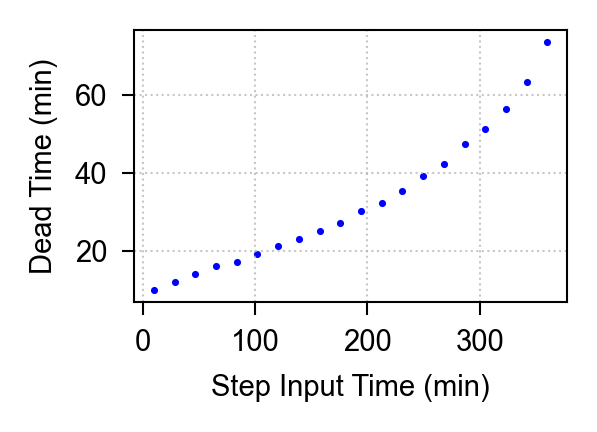

In [8]:
# Publication figure 

# Estimate the dead time in each case by varying input time 
dead_time_result_array = np.zeros(N_trajectories)
#tshold = np.max(sol_green[:,7]) * 532/29102 * 1

for i in range(N_trajectories):
    dead_time_result_array[i] = estimate_dead_time(result_array[:,8, i, 1], result_array[:,8, i, 0], timepoints, int(time_step_array[i]))


plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 6
})
tick_fontsize = 7

# Initialize figure
fig, ax = plt.subplots(figsize=(2, 1.45), dpi=300)

# Dead time computation
dead_time_result_array = np.zeros(N_trajectories)
for i in range(N_trajectories):
    dead_time_result_array[i] = estimate_dead_time(
        result_array[:, 8, i, 1],
        result_array[:, 8, i, 0],
        timepoints,
        int(time_step_array[i])
    )

# Scatter plot
ax.scatter(time_step_array, dead_time_result_array, color='blue', s = 0.5)
#ax.plot(time_step_array, dead_time_result_array, color='blue', linewidth = 1)

# Axis labels
ax.set_xlabel('Step Input Time (min)', labelpad=4)
ax.set_ylabel('Dead Time (min)', labelpad=4)

# Grid
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, direction='out', length=3, width=0.5)

# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Layout and save
plt.tight_layout()
#plt.savefig('figures/f. dead_time_variation_green_to_red.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)